# Value at Risk (VAR) & Conditional Value at Risk (CVAR) Analysis

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [42]:
import yfinance as yf
import datetime
from scipy.stats import norm

Get sample stock data

In [86]:
parse_date = datetime.datetime.strptime('01/01/2018', '%d/%m/%Y')
df = yf.download(['AAPL','META', 'C', 'DIS'], start=parse_date.date())['Adj Close']
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  4 of 4 completed


In [87]:
df.head()

,AAPL,C,DIS,META
Date,,,,
2018-01-02,40.888058,62.809452,108.726051,181.419998
2018-01-03,40.880947,63.003704,109.192848,184.669998
2018-01-04,41.070843,63.780811,109.144241,184.330002
2018-01-05,41.538441,63.696354,108.551003,186.850006
2018-01-08,41.384155,62.953045,106.994987,188.279999


Time-series plot

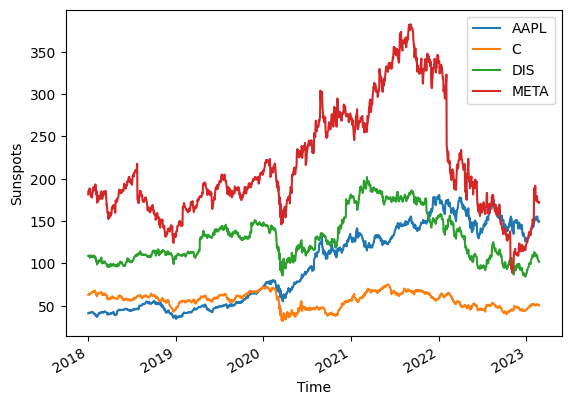

In [97]:
df.plot.line(xlabel="Time", ylabel="Sunspots");

AAPL Percentage Change Histogram

<AxesSubplot:ylabel='Frequency'>

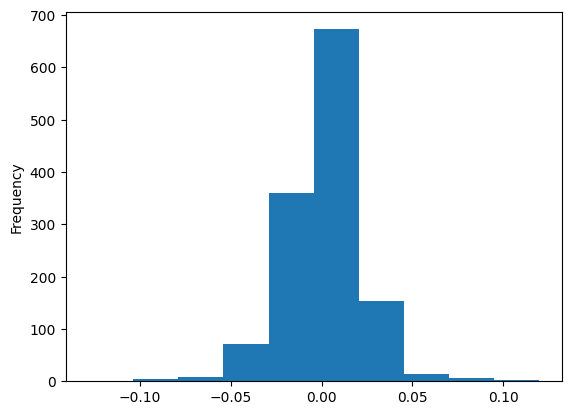

In [100]:
df['AAPL'].pct_change().plot(kind='hist')

## 1. Historical Method

In [89]:
returns = df.pct_change()

# Calculate the portfolio returns as the weighted average of the individual asset returns, assuming equal weights
weights = np.array([.25, .3, .15, .3])
port_returns = (weights * returns).sum(axis=1)

# Calculate the portfolio's VaR at a specified level of confidence (e.g., 95%) using the historical simulation method
confidence_level = 0.95
# taking the nth percentile of the sorted returns, where n is the confidence level (e.g., 5% for 95% confidence level)
var = port_returns.quantile(q=1-confidence_level)

# portfolio's CVaR as the average of the returns below the VaR level
# Taking the mean of the sorted returns below the VaR level
cvar = port_returns[port_returns <= var].mean()

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: -2.95%
CVaR at 0.95 confidence level: -4.49%


## 2. Parametric Method (Variance-Covariance)

In [90]:
# Calculate daily returns
returns = df.pct_change()

# Calculate mean and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate portfolio mean return and standard deviation
weights = np.array([.25, .3, .15, .3])
port_mean_return = (weights * mean_returns).sum()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

# Calculate VaR and CVaR using the parametric method
confidence_level = 0.95
z_score = norm.ppf(q=1-confidence_level)
var = -1 * (port_mean_return - z_score * port_std_dev)
cvar = -1 * (port_mean_return - port_std_dev * (norm.pdf(z_score)/(1-confidence_level)))

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: -3.14%
CVaR at 0.95 confidence level: 3.84%


In [96]:
cov_matrix

,AAPL,C,DIS,META
AAPL,0.000440,0.000243,0.000208,0.000337
C,0.000243,0.000584,0.000303,0.000243
DIS,0.000208,0.000303,0.000421,0.000239
META,0.000337,0.000243,0.000239,0.000776


### 2.2 Verification

In [92]:
import datetime
import yfinance as yf
from pypfopt import risk_models, expected_returns
from scipy.stats import norm

# Define start and end dates for data download
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2023, 2, 24)

# Download stock data using yfinance
stock_data = yf.download(['AAPL','META', 'C', 'DIS'], start=start_date, end=end_date)['Adj Close']

# Calculate expected returns and sample covariance matrix
mu = expected_returns.mean_historical_return(stock_data)
S = risk_models.sample_cov(stock_data)

# Use CovarianceShrinkage to shrink and regularize the covariance matrix
S = risk_models.CovarianceShrinkage(stock_data).ledoit_wolf()

# Define portfolio weights
weights = np.array([.25, .3, .15, .3])

# Calculate portfolio mean and standard deviation
portfolio_mean = (stock_data.pct_change().dropna() * weights).sum(axis=1).mean()
portfolio_std = (stock_data.pct_change().dropna() * weights).sum(axis=1).std()

# Calculate portfolio VaR and CVaR
alpha = 0.05
z_alpha = norm.ppf(alpha)
portfolio_var = -1 * (portfolio_mean - z_alpha * portfolio_std)
portfolio_cvar = -1 * (portfolio_mean - (1 / alpha) * norm.pdf(z_alpha) * portfolio_std)

# Print the results
print("Portfolio VaR (95%):", portfolio_var)
print("Portfolio CVaR (95%):", portfolio_cvar)


[*********************100%***********************]  4 of 4 completed
Portfolio VaR (95%): -0.028280739689413897
Portfolio CVaR (95%): 0.034081512908547745


## 3. Simulation

In [93]:
# Calculate daily returns
returns = df.pct_change()

# Calculate mean and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Simulate future returns using Monte Carlo method
num_simulations = 100000
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)

# Calculate simulated portfolio returns
weights = np.array([.25, .3, .15, .3])
simulated_portfolio_returns = np.dot(simulated_returns, weights)

# Calculate VaR and CVaR using Monte Carlo method
confidence_level = 0.95
var = -1 * np.percentile(simulated_portfolio_returns, 100 - confidence_level * 100)
cvar = -1 * np.mean(simulated_portfolio_returns[simulated_portfolio_returns <= -var])

print(f"VaR at {confidence_level} confidence level: {var:.2%}")
print(f"CVaR at {confidence_level} confidence level: {cvar:.2%}")

VaR at 0.95 confidence level: 3.03%
CVaR at 0.95 confidence level: 3.84%


In [94]:
simulated_returns.shape

(100000, 4)

In [95]:
mean_returns

AAPL    0.001222
C       0.000122
DIS     0.000158
META    0.000356
dtype: float64

In [2]:
n_simulations = 1000 # number of simulations to run
n_periods = 10 # number of investment periods
initial_investment = 10000 # initial investment amount
expected_return = 0.05 # expected return per period
volatility = 0.2 # standard deviation of returns per period
confidence_level = 0.95 # confidence level for CVaR


In [3]:
returns = np.random.normal(loc=expected_return, scale=volatility, size=(n_periods, n_simulations))

In [4]:
cumulative_returns = np.cumprod(1 + returns, axis=0)

In [5]:
final_investment_value = initial_investment * cumulative_returns[-1, :]

In [6]:
cvar = np.percentile(final_investment_value - initial_investment, (1-confidence_level)*100)

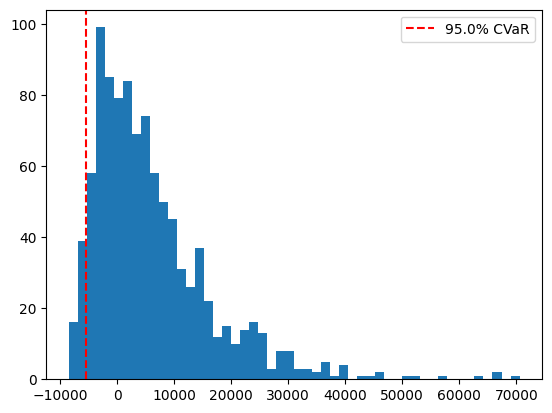

In [7]:
plt.hist(final_investment_value - initial_investment, bins=50)
plt.axvline(x=cvar, color='r', linestyle='--', label=f'{confidence_level*100}% CVaR')
plt.legend()
plt.show()